Installing the required libraries

In [ ]:
pip install autogluon==1.1.1 numpy==1.24.4  scikit-learn==1.3.2 matplotlib==3.7.1 pandas==2.1.4

In [ ]:
pip uninstall -y torch torchvision torchaudio

'''
To overcome the error/warning we will uninsiall few things and install again manually
Warning: Exception caused WaveNet to fail during training... Skipping this model. /usr/local/lib/python3.10/dist-packages/torchaudio/lib/libtorchaudio.so: undefined symbol: _ZNK3c105Error4whatEv
'''

Found existing installation: torch 2.3.1
Uninstalling torch-2.3.1:
  Successfully uninstalled torch-2.3.1
Found existing installation: torchvision 0.18.1
Uninstalling torchvision-0.18.1:
  Successfully uninstalled torchvision-0.18.1
Found existing installation: torchaudio 2.4.0+cu121
Uninstalling torchaudio-2.4.0+cu121:
  Successfully uninstalled torchaudio-2.4.0+cu121


In [ ]:
pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu121

Looking in indexes: https://download.pytorch.org/whl/nightly/cu121


Importing libraries and load AirPassenger Data set.

In [ ]:
import autogluon
#from neuralforecast.utils import AirPassengersDF
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
from autogluon.timeseries.models import WaveNetModel
import pandas as pd

# To load local csv  > modify to the right path where the file is present
Y_df = pd.read_csv('AirPassengersDataset.csv')
Y_df = Y_df.reset_index(drop=True)

#Y_df = AirPassengersDF
#Y_df = Y_df.reset_index(drop=True)
#Y_df.head()

Define calculate error metrics function which helps in assessing the performance of the trained model

In [ ]:

def calculate_error_metrics(actual, predicted, num_predictors=1):
    # convert inputs are numpy arrays
    actual = np.array(actual)
    predicted = np.array(predicted)
    # Number of observations
    n = len(actual)
    # Calculate MSE
    mse = mean_squared_error(actual, predicted)
    # Calculate RMSE
    rmse = np.sqrt(mse)
    # Calculate MAPE
    mape = mean_absolute_percentage_error(actual, predicted)
    # Calculate R-squared
    r2 = r2_score(actual, predicted)
    # Calculate Adjusted R-squared
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - num_predictors - 1))
    print(f'MSE : {mse}')
    print(f'RMSE : {rmse}')
    print(f'MAPE : {mape}')
    print(f'r2 : {r2}')
    print(f'adjusted_r2 : {adjusted_r2}')

Converting **unique_id** column to catagorical so that we can convert to the format which autogluon understands

In [ ]:

Y_df['ds'] = pd.to_datetime(Y_df['ds'])
Y_df['unique_id'] = 'airline_1'
Y_df.head()

,unique_id,ds,y
0,airline_1,1949-01-31,112
1,airline_1,1949-02-28,118
2,airline_1,1949-03-31,132
3,airline_1,1949-04-30,129
4,airline_1,1949-05-31,121


AutoGluon expects time series data in long format. Each row of the data frame contains a single observation (timestep) of a single time series represented by

unique ID of the time series ("**item_id**") as int or str

timestamp of the observation ("**timestamp**") as a pandas.Timestamp or
compatible format

numeric value of the time series ("**target**")

In [ ]:
data = TimeSeriesDataFrame.from_data_frame(
    Y_df,
    id_column="unique_id",
    timestamp_column="ds"
)
data.tail()

y
item_id   timestamp      
airline_1 1960-08-31  606
          1960-09-30  508
          1960-10-31  461
          1960-11-30  390
          1960-12-31  432

Split data into **train** and **test**

In [ ]:
train_data = data.head(132)
test_data = data.tail(12)

Create a **TimeSeriesPredictor** object to forecast future values and explicitly define WaveNetModel to be used

In [ ]:
predictor = TimeSeriesPredictor(target='y',
                                prediction_length=12,
                                 eval_metric="MASE",).fit(train_data,presets='best_quality', hyperparameters={'WaveNetModel': {}},
    time_limit=600)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'AutogluonModels/ag-20240827_212249'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       11.21 GB / 12.67 GB (88.4%)
Disk Space Avail:   63.38 GB / 107.72 GB (58.8%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': {'WaveNetModel': {}},
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 12,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'y',
 'time_limit': 600,
 'verbosity': 2}

Inferred time series frequency: 'M'
Provided train_data ha

Predict for the next defined horizon

In [ ]:
predictions = predictor.predict(train_data)
predictions.head()

Model not specified in predict, will default to the model with the best validation score: WaveNet


mean         0.1         0.2         0.3  \
item_id   timestamp                                                    
airline_1 1960-01-31  487.297943  410.974152  426.630341  448.940353   
          1960-02-29  493.169006  422.324844  440.720856  469.684723   
          1960-03-31  485.340912  422.716248  438.372437  452.854385   
          1960-04-30  489.254974  406.668716  426.630341  454.028595   
          1960-05-31  479.469864  410.974152  436.806824  452.854385   

                             0.4         0.5         0.6         0.7  \
item_id   timestamp                                                    
airline_1 1960-01-31  465.770691  487.297943  508.825134  543.660089   
          1960-02-29  483.775299  493.169006  520.567261  547.965515   
          1960-03-31  465.770691  485.340912  506.476715  529.569586   
          1960-04-30  470.467529  489.254974  504.911102  542.485870   
          1960-05-31  465.770691  479.469864  494.734619  515.087616   

                             0.8         0.9  
item_id   timestamp                           
airline_1 1960-01-31  567.535706  610.590149  
          1960-02-29  568.318518  610.590149  
          1960-03-31  555.793640  595.325427  
          1960-04-30  576.146594  602.762085  
          1960-05-31  561.273254  600.022290

Measure the models accuracy

In [ ]:
calculate_error_metrics(test_data['y'],predictions['mean']['airline_1'].tail(48))


MSE : 5787.434110611172
RMSE : 76.07518722034914
MAPE : 0.1376407025909576
r2 : -0.04476272800759307
adjusted_r2 : -0.1492390008083524


Visualize the predictions

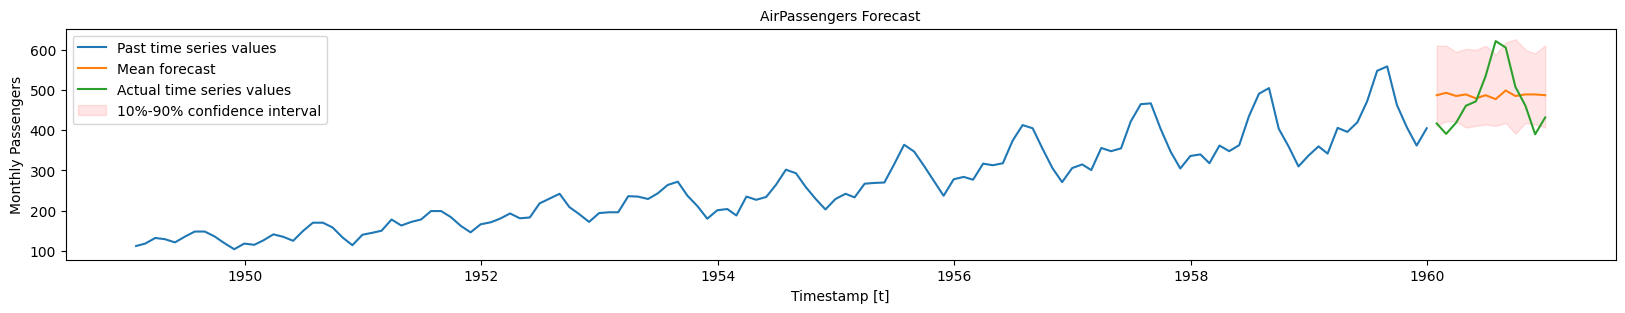

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 3))

item_id = "airline_1"
y_past = train_data.loc[item_id]["y"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["y"]

plt.plot(y_past, label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_test, label="Actual time series values")
plt.title('AirPassengers Forecast', fontsize=10)
plt.ylabel('Monthly Passengers', fontsize=10)
plt.xlabel('Timestamp [t]', fontsize=10)
plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.legend();